In [1]:
import tensorflow as tf
import numpy as np
import os

import distutils
if distutils.version.LooseVersion(tf.__version__) <= '2.0':
    raise Exception('This notebook is compatible with TensorFlow 1.14 or higher, for TensorFlow 1.13 or lower please use the previous version at https://github.com/tensorflow/tpu/blob/r1.13/tools/colab/fashion_mnist.ipynb')

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# # add empty color dimension
# x_train = np.expand_dims(x_train, -1)
# x_test = np.expand_dims(x_test, -1)

11490434/11490434 [==============================] - 0s 0us/step


In [2]:
# Display the number of samples in x_train, x_test, y_train, y_test
print("Initial shape or dimensions of x_train", str(x_train.shape))

# Print the number of samples in our data
print ("Number of samples in our training data: " + str(len(x_train)))
print ("Number of labels in our training data: " + str(len(y_train)))
print ("Number of samples in our test data: " + str(len(x_test)))
print ("Number of labels in our test data: " + str(len(y_test)))

# Print the image dimensions and no. of labels in our Training and Test Data
print("\n")
print ("Dimensions of x_train:" + str(x_train[0].shape))
print ("Labels in x_train:" + str(y_train.shape))
print("\n")
print ("Dimensions of x_test:" + str(x_test[0].shape))
print ("Labels in y_test:" + str(y_test.shape))

Initial shape or dimensions of x_train (60000, 28, 28)
Number of samples in our training data: 60000
Number of labels in our training data: 60000
Number of samples in our test data: 10000
Number of labels in our test data: 10000


Dimensions of x_train:(28, 28)
Labels in x_train:(60000,)


Dimensions of x_test:(28, 28)
Labels in y_test:(10000,)


<Figure size 432x288 with 0 Axes>

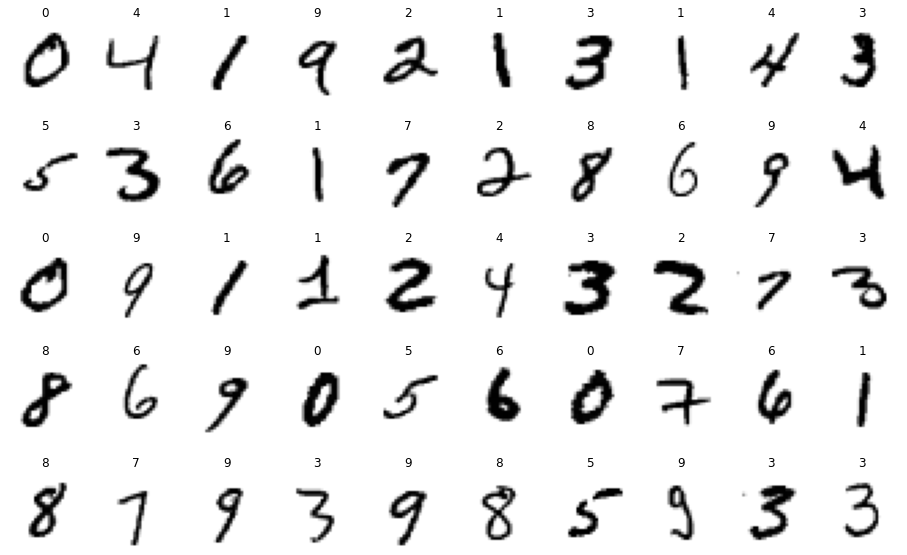

In [3]:
# Let's view the 50 first images of the MNIST training dataset
import matplotlib.pyplot as plt

# Create figure and change size
figure = plt.figure()
plt.figure(figsize=(16,10))

# Set how many images we wish to see
num_of_images = 50 

# iterate index from 1 to 51
for index in range(1, num_of_images + 1):
    plt.subplot(5, 10, index).set_title(f'{y_train[index]}')
    plt.axis('off')
    plt.imshow(x_train[index], cmap='gray_r')

In [4]:
# Lets store the number of rows and columns
img_rows = x_train[0].shape[0]
img_cols = x_train[0].shape[1]

# Getting our data in the right 'shape' needed for Keras
# We need to add a 4th dimenion to our data thereby changing our
# Our original image shape of (60000,28,28) to (60000,28,28,1)
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

# store the shape of a single image 
input_shape = (img_rows, img_cols, 1)

# change our image type to float32 data type
x_train = x_train.astype('float32') #uint8 originally
x_test = x_test.astype('float32')

# Normalize our data by changing the range from (0 to 255) to (0 to 1)
x_train /= 255.0
x_test /= 255.0

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [5]:
from tensorflow.keras.utils import to_categorical

# Now we one hot encode outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Let's count the number columns in our hot encoded matrix 
print ("Number of Classes: " + str(y_test.shape[1]))

num_classes = y_test.shape[1]
num_pixels = x_train.shape[1] * x_train.shape[2]

Number of Classes: 10


### Define the model

The following example uses a standard conv-net that has 3 layers with drop-out and batch normalization between each layer.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD 

def create_model():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  return model 

### Train on the TPU

To begin training, construct the model on the TPU and then compile it.

In [14]:
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.experimental.TPUStrategy(resolver)

with strategy.scope():
  model = create_model()
  model.compile(loss = 'categorical_crossentropy',
                optimizer = SGD(0.001),
                metrics = ['accuracy'])

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [16]:
import time
start = time.time()

history = model.fit( x_train, 
                     y_train,
                     batch_size = 128,
                     epochs=25,
                     verbose=1,
                     validation_data=(x_test, y_test)
)

score = model.evaluate(x_test, y_test, verbose = 0)
print('Test Loss: ', score[0])
print('Test Accuracy: ', score[1])
print("Total time: ", time.time() - start, "seconds") 

Epoch 1/25
469/469 [==============================] - 10s 22ms/step - loss: 0.1872 - accuracy: 0.9457 - val_loss: 0.1786 - val_accuracy: 0.9479
Epoch 2/25
469/469 [==============================] - 10s 21ms/step - loss: 0.1830 - accuracy: 0.9467 - val_loss: 0.1735 - val_accuracy: 0.9497
Epoch 3/25
469/469 [==============================] - 10s 21ms/step - loss: 0.1788 - accuracy: 0.9485 - val_loss: 0.1707 - val_accuracy: 0.9496
Epoch 4/25
469/469 [==============================] - 10s 21ms/step - loss: 0.1748 - accuracy: 0.9495 - val_loss: 0.1693 - val_accuracy: 0.9504
Epoch 5/25
469/469 [==============================] - 10s 21ms/step - loss: 0.1711 - accuracy: 0.9505 - val_loss: 0.1639 - val_accuracy: 0.9517
Epoch 6/25
469/469 [==============================] - 10s 22ms/step - loss: 0.1676 - accuracy: 0.9516 - val_loss: 0.1604 - val_accuracy: 0.9532
Epoch 7/25
469/469 [==============================] - 11s 23ms/step - loss: 0.1640 - accuracy: 0.9526 - val_loss: 0.1585 - val_accuracy:

In [17]:
model.save_weights('./mnist.h5', overwrite=True)

### Check the results (inference)

Now that you are done training, see how well the model can predict fashion categories!

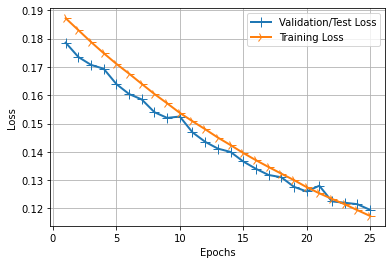

In [19]:
history_dict = history.history

# Plotting our loss charts
import matplotlib.pyplot as plt

# Use the History object we created to get our saved performance results
history_dict = history.history

# Extract the loss and validation losses
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Get the number of epochs and create an array up to that number using range()
epochs = range(1, len(loss_values) + 1)

# Plot line charts for both Validation and Training Loss
line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

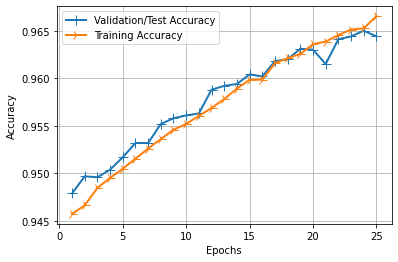

In [20]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

313/313 [==============================] - 7s 18ms/step


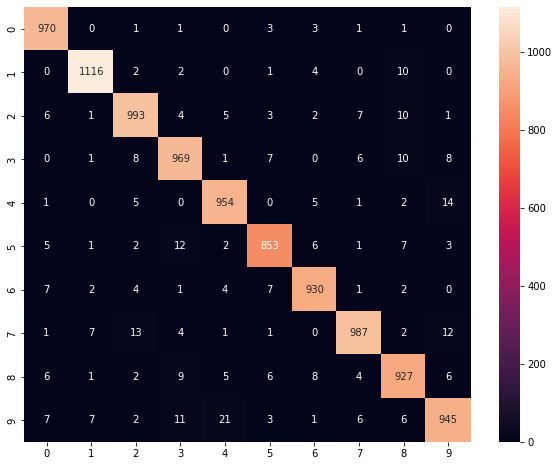

In [21]:
import numpy as np
import seaborn as sns 

# Predict the values from the testing dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert testing observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes) 

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')